# Navigation

---

### 1. Start the Environment

Set the path to the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="./Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [9]:
env.close()

### 4. Agents

There are 5 types of agents:
- DQN: Vanilla Deep-Q-Network
- DDQN: double DQN leveraging target Q network to evaluate the Q value) during training
- Prioritized: DQN trained with prioritized experience replay (https://arxiv.org/pdf/1511.05952.pdf) during training
- Dueling: Modified DQN with Q(state, action) = Q0(state) + A(state, action). As defined this DQN has fewer weights than the vanilla DQN
- DDQN+Prioritized+Dueling

The prioritized replay parameters are a tuple:
(enable/disable, epsilon, alpha, beta, beta_decay). If enabled, the other parameters are used as follows:
- epsilon is the minimum experience weight (small float > 0)
- alpha is the probability smoothing exponent (typically ~ 0.1)
- beta is the importance weighing exponent initial value (must be 0 < <= 1). Typically set to a lower value (-> uniform update), it progressively converges toward 1 (see beta_decay)
- at each episode (1-beta) is multiplied by beta_decay, resulting in beta converging toward 1. Must be <= 1. Typically close to 1.

In [5]:
from agent import Agent
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

agent_dqn = Agent(state_size, action_size, seed=0)
agent_ddqn = Agent(state_size, action_size, seed=0, use_double_dqn=True)
agent_prio = Agent(state_size, action_size, seed=0,
                   prioritized_replay=(True,0.01,0.1,0.4,0.995))
agent_duel = Agent(state_size, action_size, seed=0, use_dueling=True)
agent_ddqn_prio_duel = Agent(state_size=37, action_size=4, seed=0,
                             use_double_dqn=True,
                             prioritized_replay=(True,0.01,0.1,0.4,0.995),
                             use_dueling=True)

### 5. Training
The dqn() method trains an agent for up to 1000 episodes (default).

For each episode, the average of the scores over the previous 100 episodes is returned. 
If the average exceeds success_thr = 17, training is considered to be high successful and terminated. The treshold is chosen high enough to observe differences between agent types. All agents, as define exceed a score of 15 and some exceed 17. 

The weights corresponding to score average are saved in 'checkpoint_'+name+'.pth'

In [3]:
def dqn(agent, name='', success_thr=17, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    best_mean = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)

            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=best_mean:
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_'+name+'.pth')
            best_mean = np.mean(scores_window)
        if np.mean(scores_window)>=success_thr:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    return scores


#### DQN training and plot

Episode 100	Average Score: 1.12
Episode 200	Average Score: 4.88
Episode 300	Average Score: 8.34
Episode 400	Average Score: 10.43
Episode 500	Average Score: 13.34
Episode 600	Average Score: 14.28
Episode 700	Average Score: 14.95
Episode 800	Average Score: 15.07
Episode 900	Average Score: 14.62
Episode 1000	Average Score: 14.93


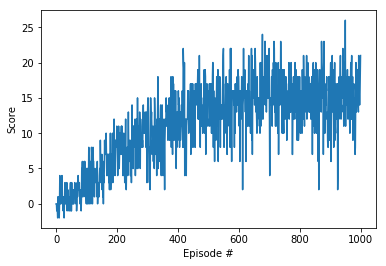

In [7]:
scores_dqn = dqn(agent_dqn,name="dqn")
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_dqn)), scores_dqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


#### Double DQN training and plot

Episode 100	Average Score: 0.89
Episode 200	Average Score: 3.70
Episode 300	Average Score: 7.31
Episode 400	Average Score: 10.00
Episode 500	Average Score: 13.55
Episode 600	Average Score: 13.94
Episode 700	Average Score: 14.84
Episode 800	Average Score: 14.92
Episode 900	Average Score: 15.95
Episode 1000	Average Score: 16.04


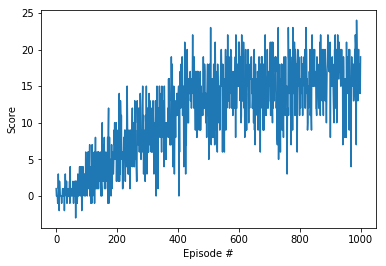

In [8]:
scores_ddqn = dqn(agent_ddqn,name="ddqn")
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddqn)), scores_ddqn)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


#### Prioritized replay DQN training and plot

Episode 100	Average Score: 1.01
Episode 200	Average Score: 4.35
Episode 300	Average Score: 8.16
Episode 400	Average Score: 10.54
Episode 500	Average Score: 13.28
Episode 600	Average Score: 14.45
Episode 700	Average Score: 14.84
Episode 800	Average Score: 15.88
Episode 900	Average Score: 16.43
Episode 974	Average Score: 17.00
Environment solved in 874 episodes!	Average Score: 17.00


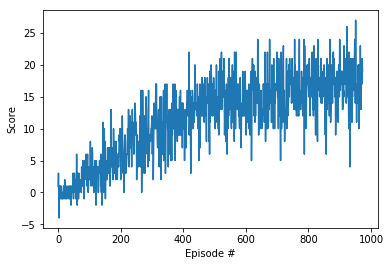

In [9]:
scores_prio = dqn(agent_prio,name="prioritized")
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_prio)), scores_prio)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


#### Dueling DQN training and plot

Episode 100	Average Score: 0.90
Episode 200	Average Score: 4.63
Episode 300	Average Score: 7.70
Episode 400	Average Score: 10.84
Episode 500	Average Score: 13.49
Episode 600	Average Score: 13.49
Episode 700	Average Score: 14.51
Episode 800	Average Score: 14.83
Episode 900	Average Score: 14.87
Episode 1000	Average Score: 15.79


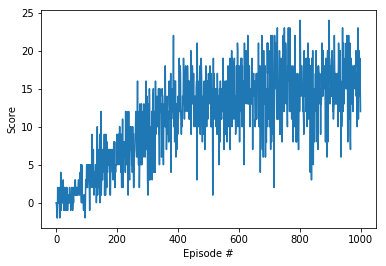

In [7]:
scores_duel = dqn(agent_duel,name="dueling")
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_duel)), scores_duel)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


#### Double + Dueling + Prioriotized DQN training and plot

Episode 100	Average Score: 1.83
Episode 200	Average Score: 6.41
Episode 300	Average Score: 9.56
Episode 400	Average Score: 11.63
Episode 500	Average Score: 14.11
Episode 600	Average Score: 14.93
Episode 700	Average Score: 14.82
Episode 800	Average Score: 15.40
Episode 900	Average Score: 16.32
Episode 951	Average Score: 17.05
Environment solved in 851 episodes!	Average Score: 17.05


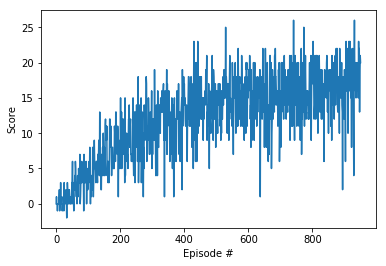

In [10]:
scores_ddqn_prio_duel = dqn(agent_ddqn_prio_duel,name="ddqn_prioritized_dueling")
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_ddqn_prio_duel)), scores_ddqn_prio_duel)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Test
Run all agents in evaluation mode.
Evaluate average/median scores over 40 episodes.

In [6]:
agent_name_list = ["dqn"    , "ddqn"    , "prioritized", "dueling" , "ddqn_prioritized_dueling"]
agent_list      = [agent_dqn, agent_ddqn, agent_prio   , agent_duel, agent_ddqn_prio_duel]

n_test_episodes = 40     # Number of episodes to average scores over
max_t           = 500    # Maximum number of steps per episode
score={}                 # Agents' scores
margin = n_test_episodes//10 # For outlier rejection

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
    
for agent_name,agent in zip(agent_name_list, agent_list):
    score[agent_name] = [] 
    agent.qnetwork_local.load_state_dict(torch.load(f'checkpoint_{agent_name}.pth',
                                                    map_location=map_location))
    for i in range(n_test_episodes):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        episode_score = 0                                  # initialize the episode score
        t = 0                                              # initialize number of steps
        while True:
            action = agent.act(state, 0)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            episode_score += reward                        # update the score
            state = next_state                             # roll over the state to next time step
            t += 1
            if done or t == max_t:                         # exit loop if episode finished
                break
        score[agent_name].append(episode_score)               
    # Remove outliers: 10% lowest scores and 10% highest scores
    agent_score = np.array(score[agent_name])
    agent_score.sort()
    agent_score = agent_score[margin:-margin]
    # Agent's average and median scores 
    print(f"Agent {agent_name}\t\t\t| mean score = {np.mean(agent_score):.2f} | median score: {np.median(agent_score):.2f}")

Agent dqn			| mean score = 15.28 | median score: 16.50
Agent ddqn			| mean score = 16.81 | median score: 17.00
Agent prioritized			| mean score = 17.50 | median score: 18.00
Agent dueling			| mean score = 16.75 | median score: 17.00
Agent ddqn_prioritized_dueling			| mean score = 16.84 | median score: 16.00
